# 0.0. IMPORTS

In [31]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt



## 0.1.0 Helper Functions

## 0.2.0. Loading Data

In [2]:
# arquivo com as vendas das lojas
df_sales_raw = pd.read_csv( 'data/train.csv', low_memory = False )

# arquivo com as caracteristicas das lojas
df_store_raw = pd.read_csv( 'data/store.csv', low_memory = False )

# merge com base na chave comum "Store"
df_raw = pd.merge( df_sales_raw, df_store_raw, how = 'left', on = 'Store' )

# 1.0. DESCRIÇÃO DOS DADOS

In [3]:
df1 = df_raw.copy()

## Explicação das colunas

* store - ID único para cada loja


* day_of_week - dia da semana em números inteiros


* date - data que foi feita a venda


* sales - valor das vendas em determinado dia


* customers - número de clientes em determinado dia


* open - indicador se a loja estava aberta e fechada 0 = closed, 1 = open


* promo - Indica se a loja estava com promoção naquele dia


* state_holiday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None


* school_holiday - indicates if the (Store, Date) was affected by the closure of public schools



* store_type - differentiates between 4 different store models: a, b, c, d


* assortment - describes an assortment level: a = basic, b = extra, c = extended


* competition_distance - distance in meters to the nearest competitor store


* competition_open_since_month - gives the approximate month of the time the nearest competitor was opened


* competition_open_since_year - gives the approximate year of the time the nearest competitor was opened


* promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating



* promo2_since_week - describes the week when the store started participating in Promo2


* promo2_since_year - describes the year when the store started participating in Promo2


* promo_interval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store



## 1.1. Rename Columns

In [4]:
# crio uma lista com o nome das colunas antigos
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
           'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
           'CompetitionDistance', 'CompetitionOpenSinceMonth',
           'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
           'Promo2SinceYear', 'PromoInterval']

# coloco as colunas no estilo snake_case
snake_case = lambda x : inflection.underscore( x ) # defino a lambda function

# aplico o map para cada nome cols_old e crio a lista cols_new
cols_new = list( map( snake_case, cols_old ) )

# renomeio as coluanas do dataset
df1.columns = cols_new

## 1.2. Data Dimensions

In [5]:
print( 'Number of rows {}'.format( df1.shape[0] ) )
print( 'Number of columns {}'.format( df1.shape[1] ) )

Number of rows 1017209
Number of columns 18


## 1.3. Data Types

In [6]:
# alterando o tipo da coluna date de int para date 64 
df1['date'] = pd.to_datetime( df1['date'] )

# exibindo os tipos de dados
print( df1.dtypes )

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object


## 1.4. Check NA

In [7]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [8]:
#competition_distance - Considero que na é igual a não competição. Se eu subsituir na por uma distancia muito grande seria o mesmo que dizer que não existe competição ( o valor máximo df1['competition_distance'] é 75860.0 )
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000 if math.isnan( x ) else x )


#competition_open_since_month - Considero que quando tiver "na" o competidor abriu no mesmo mes da coluna date ( data da venda ) -- para cada linha "na" pego o mes da coluna date e substituo na coluna competition_open_since_month
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis = 1 )

#competition_open_since_year - mesma lógica do competition_open_since_month mas aplicado ao ano
df1['competition_open_since_year'] = df1.apply( lambda x : x['date'].year if math.isnan( x['competition_open_since_year']                                                 ) else x['competition_open_since_year'], axis = 1)

#promo2_since_week - Vou considerar que onde tiver "na" a loja não participou da promoção. Então vou substituir o na pela semana da data na coluna date ( data da venda)
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'] , axis = 1)

#promo2_since_year - mesma lógica da promo2_since_week só que substituindo pelo ano
df1['promo2_since_year'] = df1.apply( lambda x : x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'] , axis = 1 )

#promo_interval
month_map = { 1 : 'Jan', 2 :  'Feb', 3 : 'Mar', 4 : 'Apr', 5 : 'May', 6 : 'Jun', 7 : 'Jul', 8 : 'Aug', 9 : 'Sept', 10 : 'Oct', 11 : 'Nov', 12 : 'Dec'  } # crio um dicionario com os meses de acordo com os valores da coluna promo_interval

df1['month_map'] = df1['date'].dt.month.map( month_map ) # substituo o numero do mes pelo nome

df1['promo_interval'].fillna( 0 , inplace = True ) # substituo os na por 0

df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x : 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis = 1) # para cada linha verifico se o valor da coluna month_map existe na coluna promo_interval, se existir retorno 1 ( participa da promoção ) se não existir 0 ( não participa )



## 1.6. Change Types

In [9]:
# verifico se durante a etapa de fill na os tipos de dados se mantiveram inalterados
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [10]:
# alterando o tipo da coluna competition_open_since_month  de float64 para int
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( 'int64' )

# alterando o tipo da coluna competition_open_since_year de float64 para int
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( 'int64' )

# alterando o tipo da coluna promo2_since_week de float 64para int
df1['promo2_since_week'] = df1['promo2_since_week'].astype( 'int64' )

# alterando o tipo da coluna promo2_since_year de float64 para int
df1['promo2_since_year'] = df1['promo2_since_year'].astype( 'int64' ) 

In [11]:
# verifico novamente o tipo de dados
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7. Descriptive Statistical

In [12]:
# selecionando somente as variáveis numéricas
num_attributes = df1.select_dtypes( include = ['int64','float64'] )

# selecionando somente as variáveis categóricas
cat_attributes = df1.select_dtypes( exclude = ['int64','float64','datetime64[ns]'] )

## 1.7.1 Numerical Attributes

In [13]:
# Central tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T # calculado a media das colunas -- aplica em todas colunas
ct2 = pd.DataFrame( num_attributes.apply( np.median) ).T # calculando a mediana

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T # calculando o std 
d2 = pd.DataFrame( num_attributes.apply( np.min ) ).T # calculando o min
d3 = pd.DataFrame( num_attributes.apply( np.max ) ).T # calculando o max
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min()  ) ).T # calcula o range
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T # calcula o skew
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T # calcula o kurtosis

# concatenate
m = pd.concat( [d2,d3,d4,ct1,ct2,d1,d5,d6] ).T.reset_index()
m.columns = ['features','min','max','range','mean','median','std','skew','kurtosis'] 
m

,features,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


## 1.7.2 Categorical Attributes

In [18]:
# verifico quantos valores unicos tenho nos atributos categoricos
print( cat_attributes.apply( lambda x: x.unique().shape[0] ) )

# verifico os valores unicos tenho nos atributos categoricos
print( cat_attributes.apply( lambda x: x.unique() ) )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64
state_holiday                                          [0, a, b, c]
store_type                                             [c, a, d, b]
assortment                                                [a, c, b]
promo_interval    [0, Jan,Apr,Jul,Oct, Feb,May,Aug,Nov, Mar,Jun,...
month_map         [Jul, Jun, May, Apr, Mar, Feb, Jan, Dec, Nov, ...
dtype: object


<Axes: xlabel='assortment', ylabel='sales'>

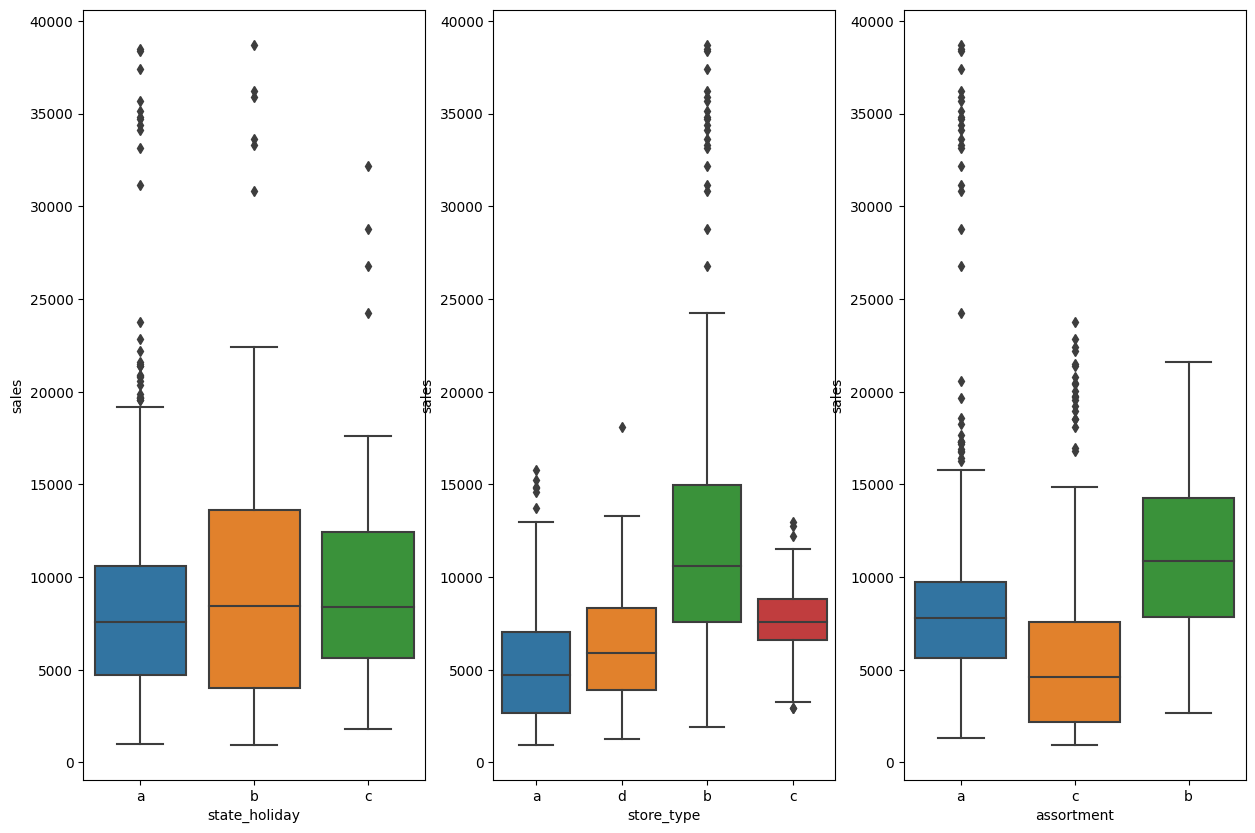

In [37]:
# filtro o df1 para plotar o grafico
aux1 = df1.loc[ (df1['state_holiday'] != '0') & (df1['sales'] > 0), : ]

# defino o tamanho dos graficos
plt.figure( figsize = ( 15,10 ) )

# plotando o grafico boxplot para entender a dispersao das variaveis categoricas em relacao as vendas 
plt.subplot( 1 ,3 , 1 )
sns.boxplot( x = 'state_holiday', y = 'sales', data = aux1 )

plt.subplot( 1, 3 , 2 )
sns.boxplot( x = 'store_type', y = 'sales', data = aux1 )

plt.subplot( 1, 3 , 3 )
sns.boxplot( x = 'assortment', y = 'sales', data = aux1 )

# .0

# .0